## 과제 : sarcastic 뉴스 이진분류 모델 만들기

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

In [75]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/jeon-
[nltk_data]     yewon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
stop = set(stopwords.words('english'))

In [77]:
# 숙제 : sarcastic 뉴스 이진분류 모델 만들기
import pandas as pd

df=pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [79]:
df['is_sarcastic']

0        1
1        0
2        0
3        1
4        1
        ..
28614    1
28615    1
28616    0
28617    1
28618    1
Name: is_sarcastic, Length: 28619, dtype: int64

In [80]:
del df['article_link']

In [81]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [82]:
print(df['headline'])

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails why congress is falling...
2        eat your veggies: 9 deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word 'strea...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object


<Axes: xlabel='is_sarcastic', ylabel='count'>

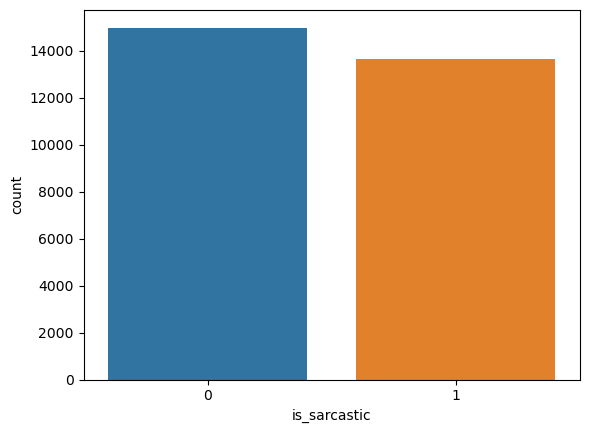

In [83]:
sns.countplot(x='is_sarcastic', data=df)

In [84]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def noise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [85]:
df['headline'] = df['headline'].apply(noise_text)

In [86]:
print(df['headline'])

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails congress falling short ...
2             eat veggies: 9 deliciously different recipes
3             inclement weather prevents liar getting work
4        mother comes pretty close using word 'streamin...
                               ...                        
28614               jews celebrate rosh hashasha something
28615    internal affairs investigator disappointed con...
28616    beautiful acceptance speech week came queer ko...
28617    mars probe destroyed orbiting spielberg-gates ...
28618                              dad clarifies food stop
Name: headline, Length: 28619, dtype: object


In [87]:
import numpy as np
import os

path_to_glove_file = 'glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs 

In [88]:
def text_to_glove(text, embeddings_index, embedding_dim=100):
    words = text.split()
    embeddings = [embeddings_index.get(word, np.zeros(embedding_dim)) for word in words]
    return np.mean(embeddings, axis=0)

In [89]:
df['glove_vector'] = df['headline'].apply(lambda x: text_to_glove(x, embeddings_index))

In [90]:
df['glove_vector']

0        [0.21244313, 0.17904787, 0.31393856, -0.169291...
1        [-0.03735069930553436, 0.30278760101646185, 0....
2        [-0.43597834060589474, 0.43384166186054546, 0....
3        [-0.14179169, -0.14692502, 0.43380165, 0.02554...
4        [-0.10860499739646912, 0.2507457509636879, 0.3...
                               ...                        
28614    [0.17014140710234643, 0.127564001083374, -0.16...
28615    [-0.23489568, -0.11133999, 0.438098, -0.330814...
28616    [0.21874285, 0.14630325, 0.45217857, 0.1680757...
28617    [-0.2126755714416504, 0.10907453724316188, 0.3...
28618    [0.0406725, 0.2724775, 0.51979244, -0.19704425...
Name: glove_vector, Length: 28619, dtype: object

In [91]:
X = np.stack(df['glove_vector'].values)
y = df['is_sarcastic'].values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [94]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(1, 100)))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [95]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [97]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
287/287 [==============================] - 3s 6ms/step - loss: 0.6062 - accuracy: 0.6751 - val_loss: 0.5577 - val_accuracy: 0.7176
Epoch 2/20
287/287 [==============================] - 1s 5ms/step - loss: 0.5668 - accuracy: 0.7081 - val_loss: 0.5498 - val_accuracy: 0.7192
Epoch 3/20
287/287 [==============================] - 1s 5ms/step - loss: 0.5535 - accuracy: 0.7202 - val_loss: 0.5439 - val_accuracy: 0.7307
Epoch 4/20
287/287 [==============================] - 2s 7ms/step - loss: 0.5449 - accuracy: 0.7270 - val_loss: 0.5349 - val_accuracy: 0.7327
Epoch 5/20
287/287 [==============================] - 4s 14ms/step - loss: 0.5400 - accuracy: 0.7300 - val_loss: 0.5334 - val_accuracy: 0.7309
Epoch 6/20
287/287 [==============================] - 3s 11ms/step - loss: 0.5348 - accuracy: 0.7356 - val_loss: 0.5285 - val_accuracy: 0.7347
Epoch 7/20
287/287 [==============================] - 3s 10ms/step - loss: 0.5261 - accuracy: 0.7383 - val_loss: 0.5256 - val_accuracy: 0.7338
Epo

In [98]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

179/179 [==============================] - 0s 2ms/step - loss: 0.5072 - accuracy: 0.7566
Test Loss: 0.5071666240692139
Test Accuracy: 0.7566387057304382


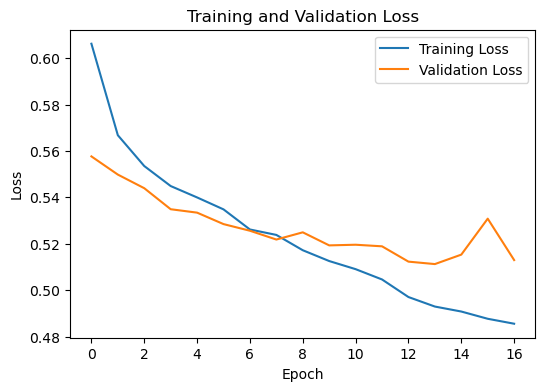

In [99]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

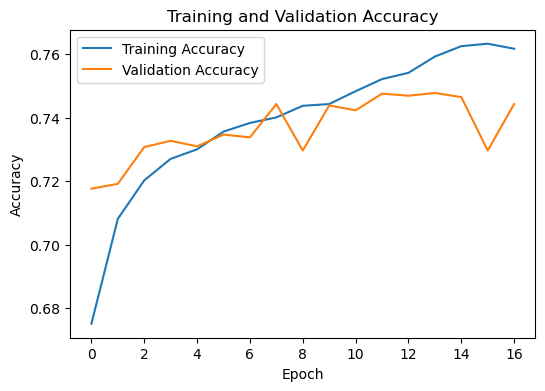

In [100]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [101]:
# 강사님 코드

In [236]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re, string, unicodedata
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU, TimeDistributed
import tensorflow as tf

In [237]:
df=pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## 과정 정리
1) article_link 삭제
2) 결측치 확인
3) 중복 확인 후 제거
4) is_sarcastic 분포 확인
5) 텍스트 전처리
6) max length 지정/분류처리/토큰화(인코딩)

In [238]:
# 1) article_link 삭제
del df['article_link']

In [239]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [240]:
# 2) 결측치 확인
df.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

In [241]:
df.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [243]:
print(df.isnull().values.any())

False


In [244]:
# 3) 중복 확인 후 제거
df.duplicated().sum()

116

In [245]:
df.drop_duplicates(subset=['headline'], inplace=True)

<Axes: xlabel='is_sarcastic', ylabel='count'>

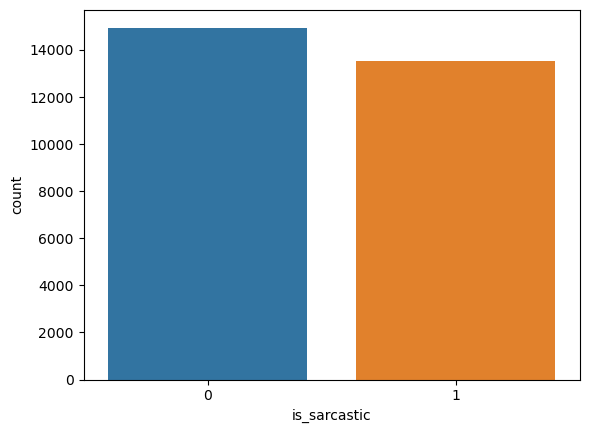

In [246]:
# 4) is_sarcastic 분포 확인
sns.countplot(x='is_sarcastic', data=df)

In [247]:
# 5) 텍스트 전처리
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [248]:
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# 함수 이름은 다르게 작성해야 한다.(동시 실행 불가)
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*]\]', '', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())

    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

df['headline'] = df['headline'].apply(denoise_text)

/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1253/2599785471.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


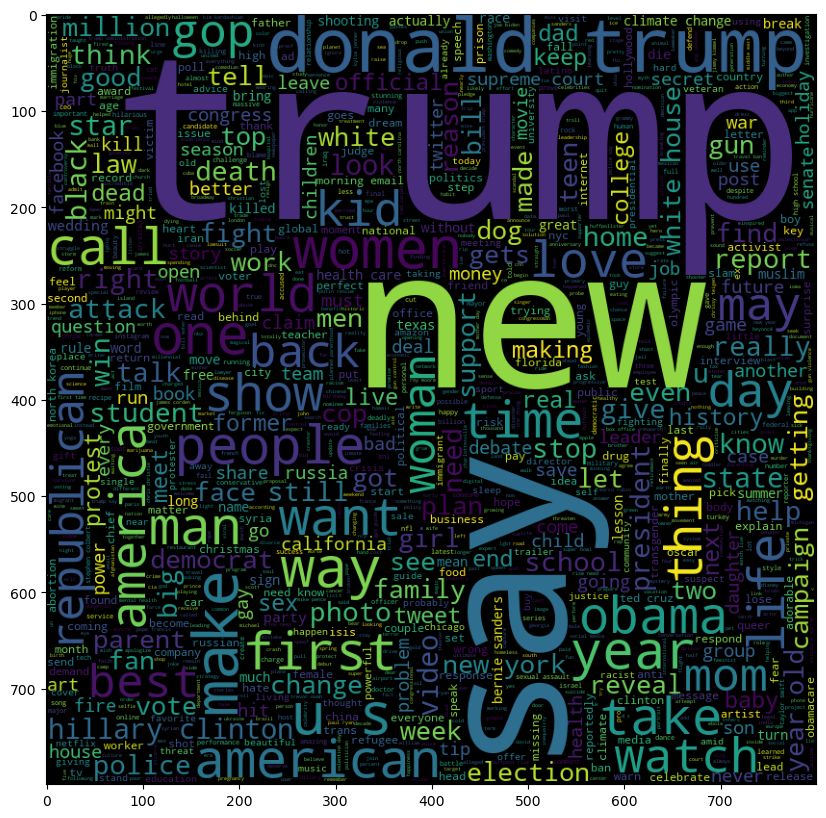

In [249]:
# + 워드 클라우드 작성
plt.figure(figsize=(10, 10))
wc = WordCloud(max_words = 2000, width=800, height=800).generate(' '.join(df[df.is_sarcastic==0].headline))
plt.imshow(wc)

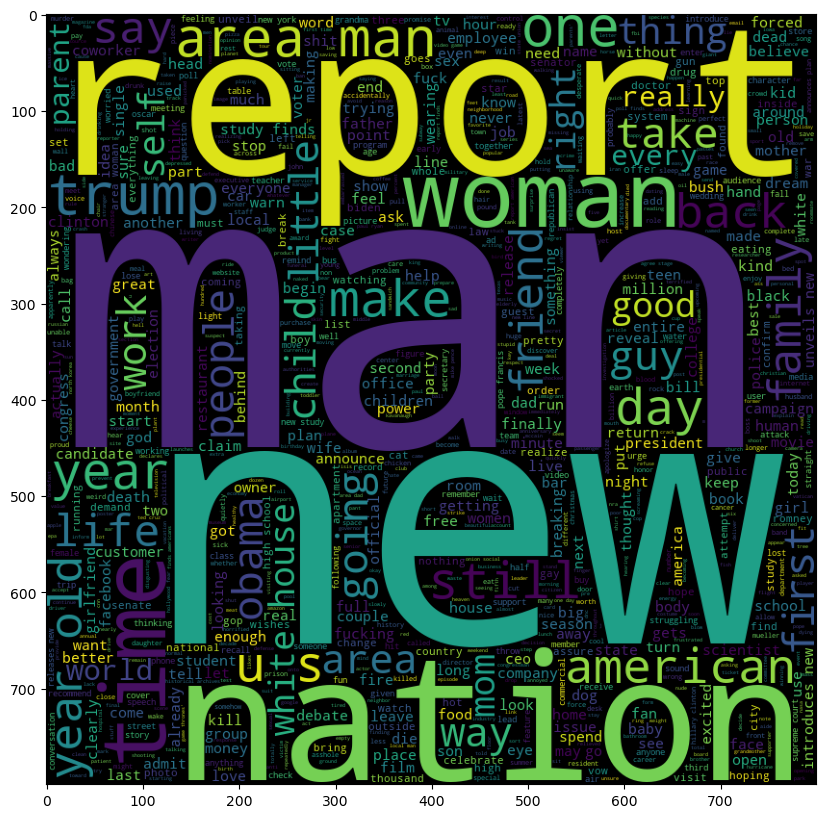

In [250]:
plt.figure(figsize=(10, 10))
wc = WordCloud(max_words = 2000, width=800, height=800).generate(' '.join(df[df.is_sarcastic==1].headline))
plt.imshow(wc)

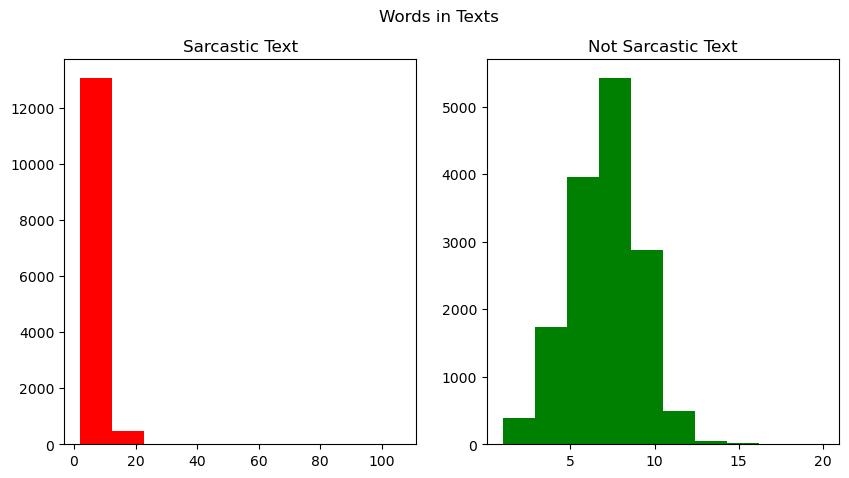

In [251]:
# + 각 분류에 따른 비율 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Sarcastic Text')

text_len = df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color='green')
ax2.set_title('Not Sarcastic Text')

fig.suptitle('Words in Texts')
plt.show()

In [252]:
# 6) max length 지정/분류처리/토큰화(인코딩)
X_data = df['headline']
y_data = df['is_sarcastic']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [254]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer() # 토큰화를 도와주는 도구
tokenizer.fit_on_texts(X_train) # 토큰화 기준 세팅
X_train_encoded = tokenizer.texts_to_sequences(X_train) # 토큰화

In [255]:
X_train_encoded[0]

[1, 171, 3119, 4674, 5360, 9825, 3418, 1749, 372, 581, 245, 130]

In [256]:
# 사전 크기 설정
maxlen = 30

word_to_index = tokenizer.word_index
vocab_size = len(word_to_index)+1

print(vocab_size)

27619


In [257]:
# 패딩 처리
X_train = pad_sequences(X_train_encoded, maxlen=maxlen)

In [258]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,  171, 3119, 4674,
       5360, 9825, 3418, 1749,  372,  581,  245,  130], dtype=int32)

In [259]:
y_train[:5]

2827     1
24271    0
20969    0
5678     1
5267     0
Name: is_sarcastic, dtype: int64

In [260]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True))) # 양방향 LSTM
model.add(TimeDistributed(Dense(1, activation='sigmoid'))) # return_sequences, TimeDistributed

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 32)          883808    
                                                                 
 bidirectional_13 (Bidirect  (None, None, 64)          16640     
 ional)                                                          
                                                                 
 time_distributed_7 (TimeDi  (None, None, 1)           65        
 stributed)                                                      
                                                                 
Total params: 900513 (3.44 MB)
Trainable params: 900513 (3.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [261]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)

In [262]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
286/286 [==============================] - 11s 31ms/step - loss: 0.5715 - acc: 0.7014 - val_loss: 0.4469 - val_acc: 0.7942
Epoch 2/10
  5/286 [..............................] - ETA: 7s - loss: 0.3445 - acc: 0.8887

/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 8s 27ms/step - loss: 0.2871 - acc: 0.8863 - val_loss: 0.4605 - val_acc: 0.7860
Epoch 3/10
286/286 [==============================] - 8s 28ms/step - loss: 0.1577 - acc: 0.9447 - val_loss: 0.5422 - val_acc: 0.7945
Epoch 4/10
286/286 [==============================] - 7s 26ms/step - loss: 0.0805 - acc: 0.9749 - val_loss: 0.6353 - val_acc: 0.7852
Epoch 4: early stopping


In [263]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test_encoded, maxlen=maxlen)

In [264]:
print('test acc : ', model.evaluate(X_test, y_test)[1])

179/179 [==============================] - 1s 3ms/step - loss: 0.5940 - acc: 0.7907
test acc :  0.7906798720359802


## Word2vec, Glove 활용

In [265]:
words = []
for i in df.headline.values:
    words.append(i.split())

print(words[:5])

[['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep.', 'totally', 'nails', 'congress', 'falling', 'short', 'gender,', 'racial', 'equality'], ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'comes', 'pretty', 'close', 'using', 'word', "'streaming'", 'correctly']]


In [266]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [267]:
EMBEDDING_DIM = 100

In [268]:
w2v_model = Word2Vec(sentences=words, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [269]:
len(w2v_model.wv)

38071

In [270]:
tokenizer = text.Tokenizer(num_words=30000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen=maxlen)

In [271]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

38072


In [272]:
x[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 16744,   231,  2822,  7158,
        2328,   555,   940], dtype=int32)

In [273]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab)+1

    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model[word]

    return weight_matrix

In [274]:
embedding_vectors = get_weight_matrix(w2v_model.wv, tokenizer.word_index)

In [295]:
# 모델 초기화
model = Sequential()

# Embedding 층 추가
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_vectors], 
                    input_length=30, 
                    trainable=True))

# Bidirectional GRU 층 추가
model.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))

# Dense 층 추가
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

# 모델 요약 정보 출력
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 30, 100)           3807200   
                                                                 
 bidirectional_16 (Bidirect  (None, 64)                25728     
 ional)                                                          
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3832993 (14.62 MB)
Trainable params: 3832993 (14.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [296]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    validation_split=0.1, 
                    epochs=10, 
                    callbacks=[es, mc])

Epoch 1/10
161/161 [==============================] - ETA: 0s - loss: 0.5956 - acc: 0.6601
Epoch 1: val_acc improved from -inf to 0.79877, saving model to best_model.h5
161/161 [==============================] - 22s 125ms/step - loss: 0.5956 - acc: 0.6601 - val_loss: 0.4283 - val_acc: 0.7988
Epoch 2/10
  1/161 [..............................] - ETA: 19s - loss: 0.3725 - acc: 0.8516

/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


161/161 [==============================] - ETA: 0s - loss: 0.2881 - acc: 0.8839
Epoch 2: val_acc improved from 0.79877 to 0.80535, saving model to best_model.h5
161/161 [==============================] - 21s 129ms/step - loss: 0.2881 - acc: 0.8839 - val_loss: 0.4338 - val_acc: 0.8053
Epoch 3/10
161/161 [==============================] - ETA: 0s - loss: 0.1341 - acc: 0.9523
Epoch 3: val_acc improved from 0.80535 to 0.80798, saving model to best_model.h5
161/161 [==============================] - 22s 135ms/step - loss: 0.1341 - acc: 0.9523 - val_loss: 0.5067 - val_acc: 0.8080
Epoch 4/10
161/161 [==============================] - ETA: 0s - loss: 0.0652 - acc: 0.9795
Epoch 4: val_acc did not improve from 0.80798
161/161 [==============================] - 21s 128ms/step - loss: 0.0652 - acc: 0.9795 - val_loss: 0.6306 - val_acc: 0.8014
Epoch 5/10
161/161 [==============================] - ETA: 0s - loss: 0.0314 - acc: 0.9911
Epoch 5: val_acc did not improve from 0.80798
161/161 [============

In [297]:
print('test acc : ', model.evaluate(X_test, y_test))

179/179 [==============================] - 1s 6ms/step - loss: 0.8541 - acc: 0.7934
test acc :  [0.8540763854980469, 0.7933695912361145]


In [298]:
pred = (model.predict(X_test) > 0.5).astype('int32')
pred[:5]

179/179 [==============================] - 1s 5ms/step


array([[0],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [299]:
cm = confusion_matrix(y_test, pred)
cm

array([[2519,  529],
       [ 649, 2004]])

<Axes: >

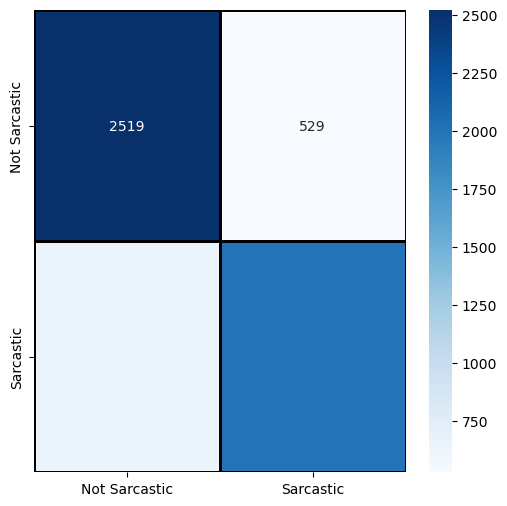

In [300]:
cm = pd.DataFrame(cm, index = ['Not Sarcastic', 'Sarcastic'], columns=['Not Sarcastic', 'Sarcastic'])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='',
            xticklabels = ['Not Sarcastic', 'Sarcastic'], yticklabels = ['Not Sarcastic', 'Sarcastic'])

In [303]:
EMBEDDING_FILE = 'glove.6B.100d.txt'

In [304]:
def get_coefs(word, *arr):
    return word, np.array(arr, dtype='float32')

with open(EMBEDDING_FILE, 'r', encoding='utf-8') as f:
    embedding_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in f)

In [309]:
# 임베딩 벡터들을 스택으로 결합하여 전체 임베딩의 평균과 표준편차를 계산합니다.
all_embs = np.stack(list(embedding_index.values()))
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

# tokenizer를 이용해 단어 인덱스를 얻어옵니다.
word_index = tokenizer.word_index
max_features = 100  # 최대 단어 수 설정

# embedding_matrix를 랜덤한 값으로 초기화합니다.
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# 각 단어에 대해 embedding_index에서 임베딩 벡터를 가져와 embedding_matrix에 할당합니다.
for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix)

[[ 0.42573881  0.01394549 -0.17947732 ...  0.55793801 -0.44567643
  -0.4744359 ]
 [-0.043959    0.18935999  0.66109997 ... -0.14168     0.92789
   0.59057999]
 [ 0.37292999  0.38503     0.71086001 ... -0.93711001  0.039138
  -0.53911   ]
 ...
 [ 0.049432    0.29907     0.070318   ...  0.21135999  1.40369999
   0.54495001]
 [-0.26424     0.22626001  0.82339001 ...  0.34128001  0.75775999
   0.10251   ]
 [-0.45785951  0.20136149 -0.04510032 ...  0.56181672  0.19585077
   0.12281005]]


In [318]:
from tensorflow.keras.optimizers import Adam

# 모델 구성
model = Sequential()
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 100)         1000000   
                                                                 
 bidirectional_21 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1084609 (4.14 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [319]:
history = model.fit(X_train, y_train, batch_size=64, validation_split=0.1, epochs=10, callbacks=[es, mc])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_26/embedding_23/embedding_lookup' defined at (most recent call last):
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1253/1190884943.py", line 1, in <module>
      history = model.fit(X_train, y_train, batch_size=64, validation_split=0.1, epochs=10, callbacks=[es, mc])
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_26/embedding_23/embedding_lookup'
indices[62,28] = 10411 is not in [0, 10000)
	 [[{{node sequential_26/embedding_23/embedding_lookup}}]] [Op:__inference_train_function_150925]

In [ ]:
print('test acc : ', model.evaluate(X_test, y_test)[1])